## Etapa 2: Modelagem e Classificação de Sentimento

In [ ]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar apenas avisos relevantes
warnings.filterwarnings('default')
sns.set(style="whitegrid")

print("Bibliotecas de modelagem carregadas!")

Bibliotecas de modelagem carregadas!


### Carregar dados processados

In [14]:
caminho = "../data/processed/reviews_processed.csv"

# Leitura com checagem mínima
try:
    df = pd.read_csv(caminho)
    print(f"Dataset carregado! Total de linhas: {len(df)}")
except FileNotFoundError:
    raise FileNotFoundError(f"Arquivo nao encontrado: {caminho}. Verifique o caminho e rode a etapa de preprocessamento (notebook 1).")

# Verificar colunas esperadas
esperadas = ['texto_limpo', 'user_suggestion']
faltando = [c for c in esperadas if c not in df.columns]
if faltando:
    raise ValueError(f"Colunas faltando no CSV processado: {faltando}. Verifique o notebook de EDA e o arquivo gerado.")

# Garantir tipo correto do target (0/1)
if not np.issubdtype(df['user_suggestion'].dtype, np.integer):
    try:
        df['user_suggestion'] = df['user_suggestion'].astype(int)
    except Exception:
        # Se for string 'positive'/'negative' (caso improvável), mapear para 1/0
        mapping = {'positive': 1, 'negative': 0, 'pos': 1, 'neg': 0}
        df['user_suggestion'] = df['user_suggestion'].map(mapping).astype(int)

X = df['texto_limpo']
y = df['user_suggestion']

Dataset carregado! Total de linhas: 17494


### Divisão Treino/Teste

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Divisão treino/teste concluída.")
print(f"Treino: {len(X_train)} | Teste: {len(X_test)}")

Divisão treino/teste concluída.
Treino: 13995 | Teste: 3499


### Vetorização (TF-IDF)

In [ ]:
tfidf = TfidfVectorizer(
    max_features=10000,   # limita para reduzir ruído
    ngram_range=(1,2),    # unigrams + bigrams
    stop_words='english'
)

X_train_vec = tfidf.fit_transform(X_train.fillna(''))
X_test_vec = tfidf.transform(X_test.fillna(''))

print("TF-IDF ajustado e transformações concluídas!")

TF-IDF ajustado e transformações concluídas!


### Função para treinar e avaliar modelos

In [17]:
def avaliar_modelo(nome, modelo, X_train, y_train, X_test, y_test):
    modelo.fit(X_train, y_train)
    preds = modelo.predict(X_test)

    acc = accuracy_score(y_test, preds)
    print(f"\n====================== {nome} ======================")
    print("Acurácia:", round(acc, 4))
    print("\nClassification Report:")
    print(classification_report(y_test, preds))

    # Matriz de confusão - rótulos dinâmicos (suporta 0/1 ou outros)
    labels = np.unique(np.concatenate([y_test.values, preds]))
    cm = confusion_matrix(y_test, preds, labels=labels)
    label_names = []
    for lab in labels:
        if lab == 0:
            label_names.append('Negativo')
        elif lab == 1:
            label_names.append('Positivo')
        else:
            label_names.append(str(lab))

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names,
                yticklabels=label_names)
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    return acc

### Modelos testados


====================== Naive Bayes ======================
Acurácia: 0.8411

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1505
           1       0.83      0.90      0.87      1994

    accuracy                           0.84      3499
   macro avg       0.84      0.83      0.84      3499
weighted avg       0.84      0.84      0.84      3499



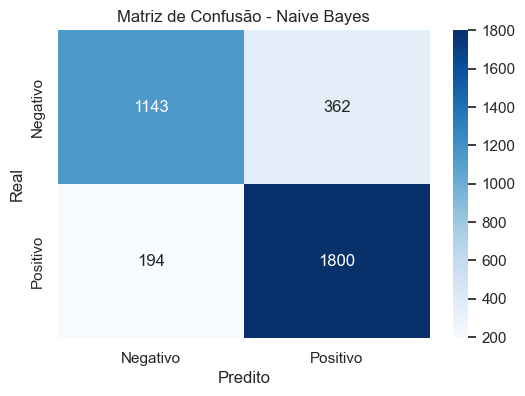


====================== Regressão Logística ======================
Acurácia: 0.8537

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1505
           1       0.85      0.90      0.88      1994

    accuracy                           0.85      3499
   macro avg       0.85      0.85      0.85      3499
weighted avg       0.85      0.85      0.85      3499



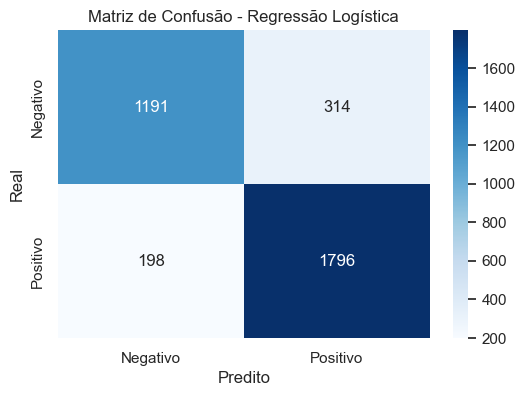


====================== SVM Linear ======================
Acurácia: 0.8428

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1505
           1       0.85      0.87      0.86      1994

    accuracy                           0.84      3499
   macro avg       0.84      0.84      0.84      3499
weighted avg       0.84      0.84      0.84      3499



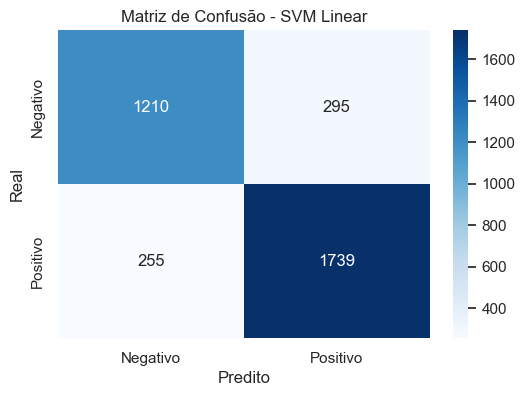

In [18]:
resultados = {}

# 1) Naive Bayes
nb = MultinomialNB()
resultados["Naive Bayes"] = avaliar_modelo("Naive Bayes", nb, X_train_vec, y_train, X_test_vec, y_test)

# 2) Regressão Logística (solver compatível)
logreg = LogisticRegression(max_iter=2000, solver='liblinear')
resultados["Regressão Logística"] = avaliar_modelo("Regressão Logística", logreg, X_train_vec, y_train, X_test_vec, y_test)

# 3) SVM Linear (aumentar max_iter para evitar warnings)
svm = LinearSVC(max_iter=5000)
resultados["SVM Linear"] = avaliar_modelo("SVM Linear", svm, X_train_vec, y_train, X_test_vec, y_test)

### Comparação final

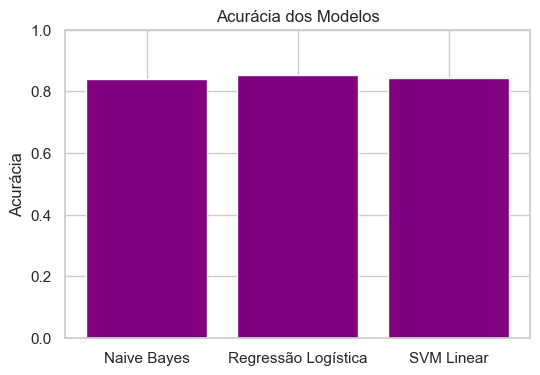


Acurácias finais dos modelos:
Naive Bayes: 0.8411
Regressão Logística: 0.8537
SVM Linear: 0.8428


In [19]:
plt.figure(figsize=(6,4))
plt.bar(resultados.keys(), resultados.values(), color="purple")
plt.title("Acurácia dos Modelos")
plt.ylabel("Acurácia")
plt.ylim(0,1)
plt.show()

print("\nAcurácias finais dos modelos:")
for modelo, acc in resultados.items():
    print(f"{modelo}: {acc:.4f}")